In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from matplotlib.animation import FuncAnimation
from scipy.spatial.distance import pdist
from IPython.display import HTML

In [2]:
# if you have difficulties with ffmpeg to run the simulation, see https://stackoverflow.com/questions/13316397/matplotlib-animation-no-moviewriters-available
# plt.rcParams['animation.ffmpeg_path'] = your_windows_path
plt.rcParams['animation.ffmpeg_args'] = '-report'
plt.rcParams['animation.bitrate'] = 2000

pd.options.display.float_format = '{:,.2f}'.format

### Load Iris Data

In [3]:
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [4]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

### Create DataFrame

In [5]:
features = iris.feature_names
data = pd.DataFrame(data=np.column_stack([iris.data, iris.target]), 
                    columns=features + ['label'])
data.label = data.label.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal length (cm)    150 non-null float64
sepal width (cm)     150 non-null float64
petal length (cm)    150 non-null float64
petal width (cm)     150 non-null float64
label                150 non-null int64
dtypes: float64(4), int64(1)
memory usage: 5.9 KB


### Standardize Data

In [6]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(data[features])
n = len(data)

### Reduce Dimensionality to visualize clusters

In [7]:
pca = PCA(n_components=2)
features_2D = pca.fit_transform(features_standardized)

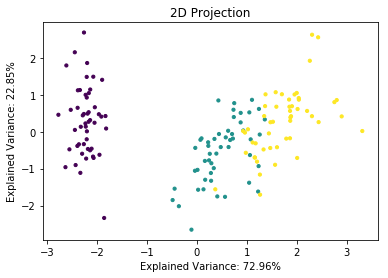

In [8]:
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure().gca(title='2D Projection', 
                      xlabel='Explained Variance: {:.2%}'.format(ev1), 
                      ylabel='Explained Variance: {:.2%}'.format(ev2))
ax.scatter(*features_2D.T, c=data.label, s=10);

### Perform agglomerative clustering

In [9]:
Z = linkage(features_standardized, 'ward')
Z[:5]

array([[1.01000000e+02, 1.42000000e+02, 0.00000000e+00, 2.00000000e+00],
       [7.00000000e+00, 3.90000000e+01, 1.21167870e-01, 2.00000000e+00],
       [1.00000000e+01, 4.80000000e+01, 1.21167870e-01, 2.00000000e+00],
       [9.00000000e+00, 3.40000000e+01, 1.31632184e-01, 2.00000000e+00],
       [0.00000000e+00, 1.70000000e+01, 1.31632184e-01, 2.00000000e+00]])

In [10]:
linkage_matrix = pd.DataFrame(data=Z, 
                              columns=['cluster_1', 'cluster_2', 
                                       'distance', 'n_objects'],
                              index=range(1, n))
for col in ['cluster_1', 'cluster_2', 'n_objects']:
    linkage_matrix[col] = linkage_matrix[col].astype(int)
linkage_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 1 to 149
Data columns (total 4 columns):
cluster_1    149 non-null int64
cluster_2    149 non-null int64
distance     149 non-null float64
n_objects    149 non-null int64
dtypes: float64(1), int64(3)
memory usage: 4.7 KB


In [11]:
linkage_matrix.head()

,cluster_1,cluster_2,distance,n_objects
1,101,142,0.00,2
2,7,39,0.12,2
3,10,48,0.12,2
4,9,34,0.13,2
5,0,17,0.13,2


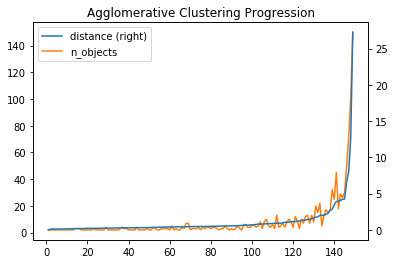

In [12]:
linkage_matrix[['distance', 'n_objects']].plot(secondary_y=['distance'], 
                        title='Agglomerative Clustering Progression');

### Compare linkage types

In [13]:
methods = ['single', 'complete', 'average', 'ward']
pairwise_distance = pdist(features_standardized)

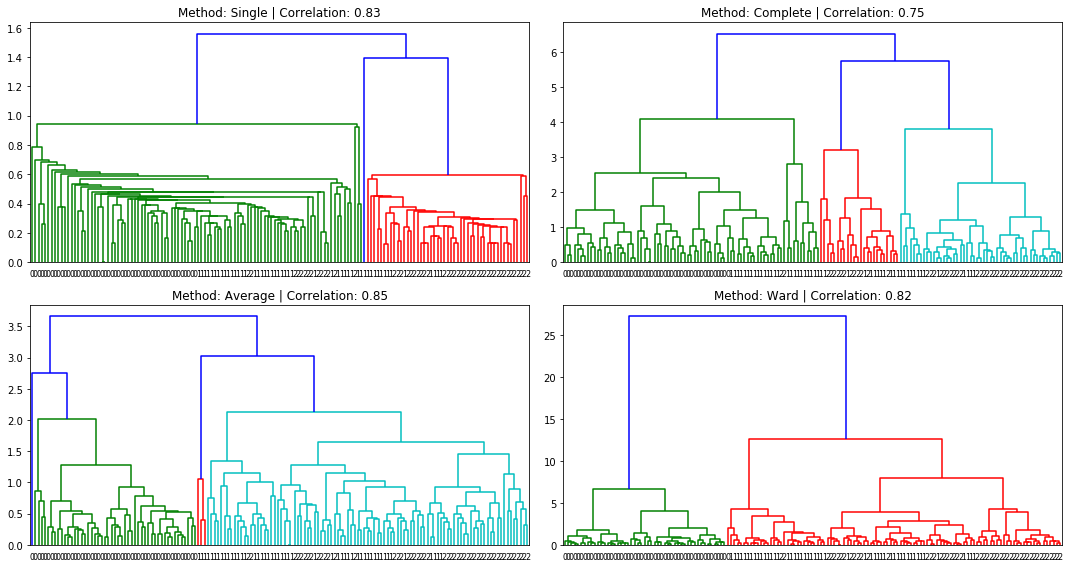

In [15]:
fig, axes = plt.subplots(figsize=(15, 8), nrows=2, ncols=2, sharex=True)
axes = axes.flatten()
for i, method in enumerate(methods):
    Z = linkage(features_standardized, method)
    c, coph_dists = cophenet(Z, pairwise_distance)
    dendrogram(Z, labels=data.label.values,
        orientation='top', leaf_rotation=0., 
        leaf_font_size=8., ax = axes[i])
    axes[i].set_title('Method: {} | Correlation: {:.2f}'.format(
                                                method.capitalize(), c))
    
fig.tight_layout()
fig.savefig('dendrogram', dpi=300)

### Get Cluster Members

In [16]:
n = len(Z)
from collections import OrderedDict
clusters = OrderedDict()

for i, row in enumerate(Z, 1):
    cluster = []
    for c in row[:2]:
        if c <= n:
            cluster.append(int(c))
        else:
            cluster += clusters[int(c)]
    clusters[n+i] = cluster

In [17]:
clusters[230]

[144, 124, 120, 143]

### Animate Agglomerative Clustering

In [18]:
def get_2D_coordinates():
    points = pd.DataFrame(features_2D).assign(n=1)
    return dict(enumerate(points.values.tolist()))

In [19]:
n_clusters = Z.shape[0]
points = get_2D_coordinates()
cluster_states = {0: get_2D_coordinates()}

for i, cluster in enumerate(Z[:, :2], 1):
    cluster_state = dict(cluster_states[i-1])
    merged_points = np.array([cluster_state.pop(c) for c in cluster])
    cluster_size = merged_points[:, 2]
    new_point = np.average(merged_points[:, :2], 
                           axis=0, weights=cluster_size).tolist()
    new_point.append(cluster_size.sum())
    cluster_state[n_clusters+i] = new_point
    cluster_states[i] = cluster_state

In [20]:
cluster_states[100]

{15: [-2.2622145316010216, 2.686284485110592, 1.0],
 41: [-1.8581224563735717, -2.337415157553348, 1.0],
 60: [-0.11019628000062932, -2.6540728185365645, 1.0],
 62: [0.5621083064431792, -1.7647243806169446, 1.0],
 106: [0.36701768786072436, -1.5615028914765063, 1.0],
 108: [2.006686467676607, -0.7114386535471587, 1.0],
 109: [2.2597773490125017, 1.9210103764598867, 1.0],
 114: [1.4676452010173247, -0.44227158737708266, 1.0],
 176: [0.28711522075373114, -0.24204262329732348, 2.0],
 179: [-2.2058211672986987, -0.09844552008358048, 2.0],
 185: [0.9688104990917799, 0.01907915384081543, 3.0],
 194: [0.7389335833626245, 0.6838170188840107, 2.0],
 197: [2.3691965862739517, 0.33967500639352843, 2.0],
 198: [-2.4657912495858, -0.9936714816693262, 3.0],
 205: [1.9290326043911596, 0.5634757376107679, 3.0],
 206: [-1.9303546578375999, 0.4980362956076001, 3.0],
 208: [-2.3324410024278306, 0.10599232941089061, 3.0],
 209: [2.365628354573734, 2.5914923595139356, 2.0],
 210: [-2.3753778947842483, -0.4

### Set up Animation

In [21]:
%%capture
fig, ax = plt.subplots()
xmin, ymin = np.min(features_2D, axis=0) * 1.1
xmax, ymax = np.max(features_2D, axis=0) * 1.1
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

In [22]:
scat = ax.scatter([], [])
def animate(i):
    df = pd.DataFrame(cluster_states[i]).values.T
    scat.set_offsets(df[:, :2])
    scat.set_sizes((df[:, 2] * 2) ** 2)
    return scat,
    
anim = FuncAnimation(
    fig, animate, frames=cluster_states.keys(), interval=250, blit=False)
HTML(anim.to_html5_video())

### Scikit-Learn implementation

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


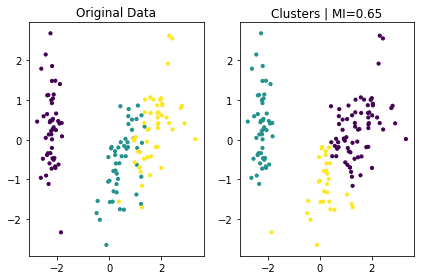

In [23]:
clusterer = AgglomerativeClustering(n_clusters=3)
data['clusters'] = clusterer.fit_predict(features_standardized)
fig, axes = plt.subplots(ncols=2)
labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)
axes[0].scatter(*features_2D.T, c=data.label, s=10)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=10)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))
plt.tight_layout()

### Comparing Mutual Information for different Linkage Options

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


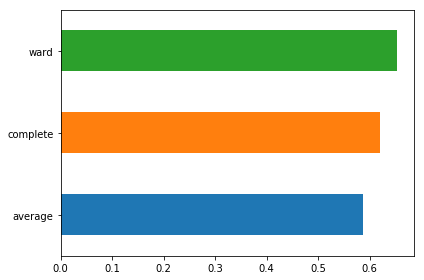

In [24]:
mutual_info = {}
for linkage_method in ['ward', 'complete', 'average']: 
    clusterer = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
    clusters = clusterer.fit_predict(features_standardized)  
    mutual_info[linkage_method] = adjusted_mutual_info_score(clusters, labels)
fig, ax = plt.subplots()
pd.Series(mutual_info).sort_values().plot.barh()
plt.tight_layout()